In [29]:
#Load all requirements
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import math

%matplotlib inline

print('Done loading all imports...')

Done loading all imports...


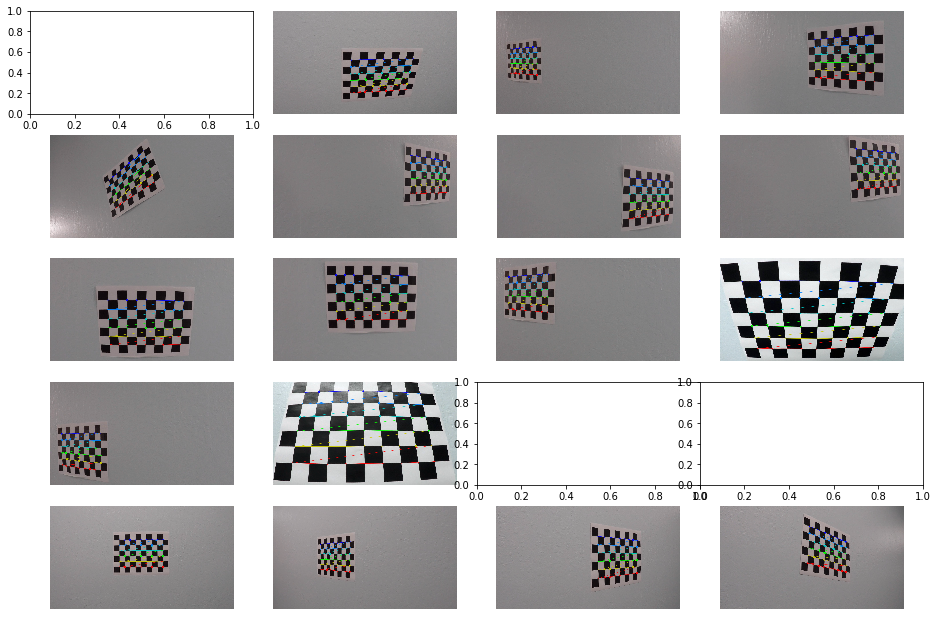

In [8]:
#Perform camera calibration ONLY ONCE!!
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

fig, axs = plt.subplots(5,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)

        # this step to refine image points was taken from:
        # http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)
    
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        axs[i].axis('off')
        axs[i].imshow(img)

        # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
cam_cal_pickle = {}
cam_cal_pickle["objpoints"] = objpoints
cam_cal_pickle["imgpoints"] = imgpoints
pickle.dump(cam_cal_pickle, open( "cam_cal.p", "wb" ) )

In [6]:
#a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
##DONT CALIBRATE CAMERA AGAIN

###EXAMPLE USAGE: undistorted, mtx,dist = cal_undistort(img, objpoints, imgpoints)
def cal_undistort(img, mtx, dist):
    # Use cv2.calibrateCamera() and cv2.undistort()
    #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #ret, corners = cv2.findChessboardCorners(gray, (8,6), None)
    #img = cv2.drawChessboardCorners(img, (8,6), corners, ret)
    #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    #undist = np.copy(img)  # Delete this line
    undist=dst
    return undist, mtx, dist

...


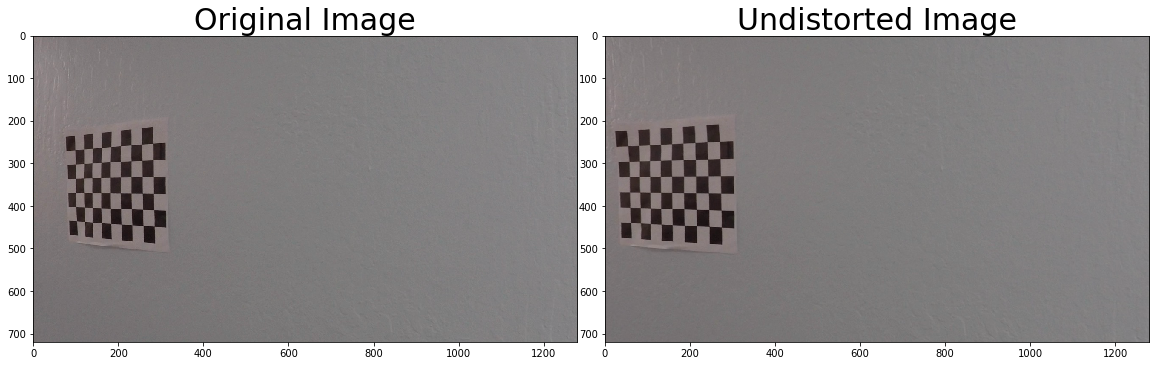

In [7]:
# Test undistortion on an image
import pickle
cam_cal_pickle=pickle.load(open( "./cam_cal.p", "rb" ) )

objpoints=cam_cal_pickle['objpoints']
imgpoints=cam_cal_pickle['imgpoints']

img = cv2.imread('./camera_cal/calibration11.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
print('...')

...


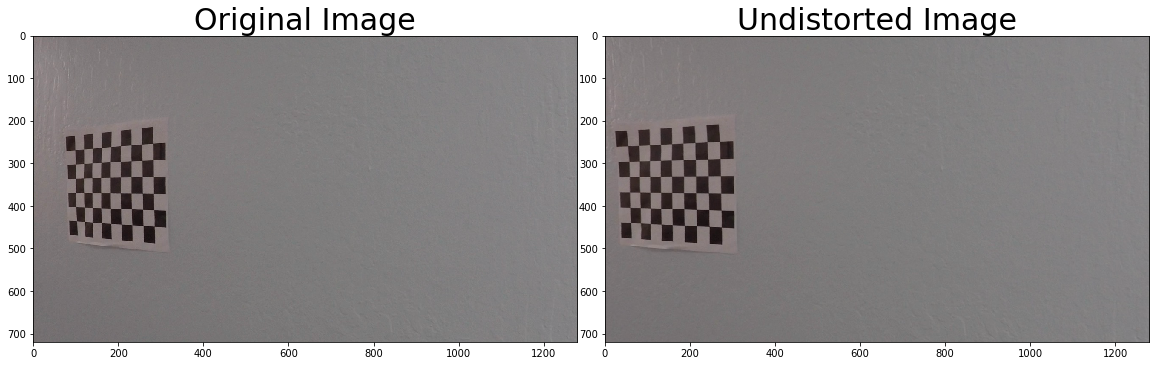

In [8]:
# Test undistortion on an image using the Undistort function and saved parameters for the pipeline
###Load saved calibration data
import pickle
dist_pickle=pickle.load(open( "./calibration.p", "rb" ) )

mtx=dist_pickle['mtx']
dist=dist_pickle['dist']

img = cv2.imread('./camera_cal/calibration11.jpg')
img_size = (img.shape[1], img.shape[0])
undist, mtx, dist=cal_undistort(img, mtx, dist)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
print('...')

...


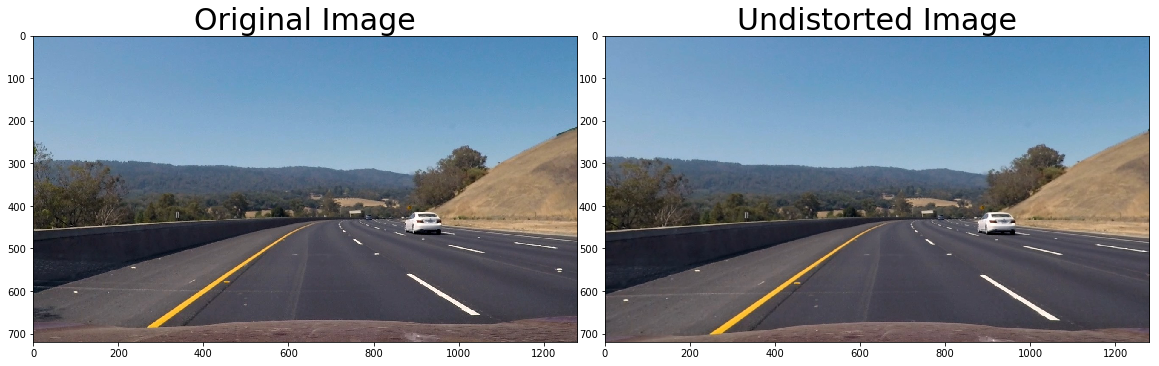

In [9]:
# Test undistortion on a Road image using the Undistort function and saved parameters for the pipeline
###Load saved calibration data
import pickle
dist_pickle=pickle.load(open( "./calibration.p", "rb" ) )

mtx=dist_pickle['mtx']
dist=dist_pickle['dist']

img = cv2.imread('./test_images/test3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])
undist, mtx, dist=cal_undistort(img, mtx, dist)
#undist = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
print('...')

In [10]:
# A function to Unwarp an image to get Bird's Eye view perspective

def warp_transform(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

...


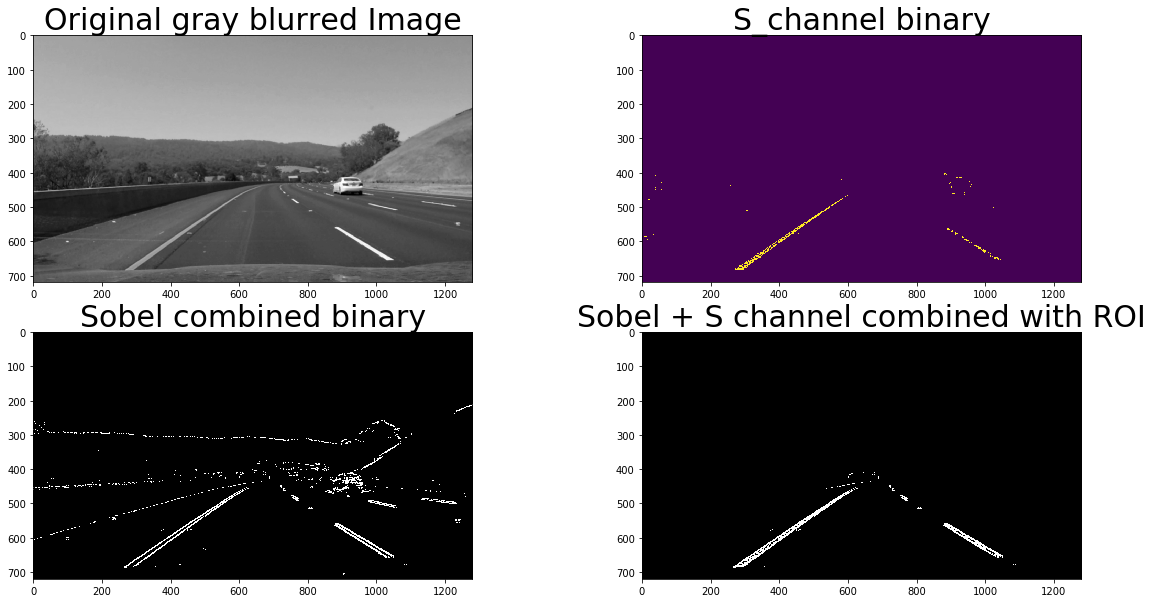

In [222]:
# Test S channel + Sobel function filters

img = cv2.imread('./test_images/test3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])


def pipeline1(img):
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]

    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #print('bgr2gray image shape',gray.shape)
    # Gaussian Blur

    kernel_size = 5
    blur = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)

    # Define sobel kernel size
    ksize = 7
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(blur, orient='x', sobel_kernel=ksize, thresh=(10, 255))
    grady = abs_sobel_thresh(blur, orient='y', sobel_kernel=ksize, thresh=(60, 255))
    mag_binary = mag_thresh(blur, sobel_kernel=ksize, mag_thresh=(40, 255))
    dir_binary = dir_threshold(blur, sobel_kernel=ksize, thresh=(.65, 1.05))
    #Directional Binary output is float64, so convert it to uint8
    dir_binary=dir_binary.astype(np.uint8)
    # Combine all the thresholding information
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    # Threshold color channel
    s_binary = np.zeros_like(combined)
    s_binary[(s > 160) & (s < 255)] = 1
    #color_binary = np.dstack(( np.zeros_like(s_binary), s_binary, s_binary)) * 255
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors    
    color_binary = np.zeros_like(combined)
    color_binary[(s_binary > 0) | (combined > 0)] = 1
    

    # Defining vertices for marked area
    imshape = img.shape
    left_bottom = (100, imshape[0])
    right_bottom = (imshape[1]-20, imshape[0])
    apex1 = (610, 410)
    apex2 = (680, 410)
    inner_left_bottom = (310, imshape[0])
    inner_right_bottom = (1150, imshape[0])
    inner_apex1 = (700,480)
    inner_apex2 = (650,480)
    vertices = np.array([[left_bottom, apex1, apex2, \
                            right_bottom, inner_right_bottom, \
                            inner_apex1, inner_apex2, inner_left_bottom]], dtype=np.int32)
    # Masked area
    color_binary = region_of_interest(color_binary, vertices)
    
    return color_binary,combined,s_binary,blur

color_binary,combined,s_binary,blur=pipeline1(img)

# Visualize 
fig, axes = plt.subplots(2, 2,figsize=(20,10))

f.subplots_adjust(hspace = .2, wspace=.05)

axes[0, 0].imshow(blur,cmap='gray')
axes[0, 0].set_title('Original gray blurred Image', fontsize=30)

axes[0, 1].imshow(s_binary)
axes[0, 1].set_title('S_channel binary', fontsize=30)

axes[1,0].set_title('Sobel combined binary', fontsize=30)
axes[1,0].imshow(combined,cmap='gray')

axes[1,1].imshow(color_binary,cmap='gray')
axes[1,1].set_title('Sobel + S channel combined with ROI', fontsize=30)
print('...')


...


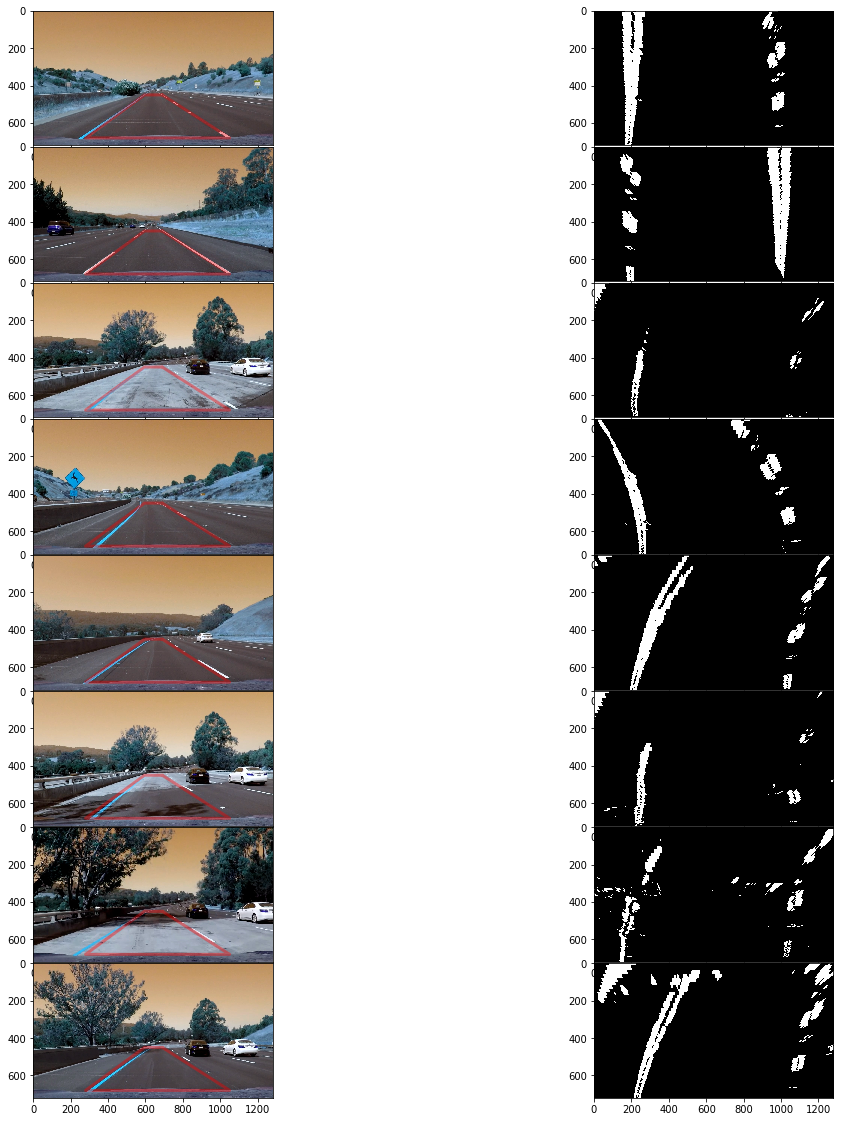

In [223]:
# Test Warp function on an undistorted image. Combine undistort +warp
def is_odd(num):
    return num & 0x1
def pipeline2(color_binary):
    img=color_binary
    dist_pickle=pickle.load(open( "./calibration.p", "rb" ) )

    mtx=dist_pickle['mtx']
    dist=dist_pickle['dist']

    img_size = (img.shape[1], img.shape[0])
    undist, mtx, dist=cal_undistort(img, mtx, dist)
    width = img.shape[1]
    height= img.shape[0]
    # define source and destination points for transform
    src = np.float32([(690,450),(595,450),
                          (1050,680),
                          (280,680), 
                          ])
    dst = np.float32([(1000,0),
                          (200,0),
                          (1000,720),
                          (200,720)])

    warp, M, Minv=warp_transform(undist,src,dst)
    
    return warp, M, Minv,src,dst

#img = cv2.imread('./test_images/straight_lines2.jpg')
#warp, M, Minv,src,dst=pipeline2(img)

# Visualize undistortion
#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
#f.subplots_adjust(hspace = .2, wspace=.05)
#ax1.imshow(img)
#x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
#y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
#ax1.plot(x, y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)

#ax1.set_title('Original Image', fontsize=30)
#ax2.imshow(warp)
#ax2.set_title('Undistorted, Warped Birds Eyeview Image', fontsize=30)
#print('...')

# Make a list of calibration images
images = glob.glob('./test_images/*.jpg')

fig, axs = plt.subplots(8,2, figsize=(20,20))
fig.subplots_adjust(hspace = .01, wspace=.01)
axs = axs.ravel()
i_original=0
i_processed=0
# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img=cv2.imread(fname)

    if(i==0):
        i_original=0
        i_processed=1
    else:
        i_original=i*2
        i_processed=i_original+1
        

    axs[i_original].imshow(img)
    color_binary,combined,s_binary,blur=pipeline1(img)
    warp, M, Minv,src,dst=pipeline2(color_binary)
    axs[i_processed].imshow(warp,cmap='gray')
    
    x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
    y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
    axs[i_original].plot(x, y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)

    
print('...')
    
    


In [224]:
# Define functions to calculate various Sobel filter functions to find lines 
# Calculate directional gradient
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply x or y gradient
    if orient == 'x':
    	sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
    	sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute values
    sobel = np.absolute(sobel)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    # Return the result
    return binary_output

# Calculate gradient magnitude
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    sobel = np.sqrt(sobelx ** 2 + sobely ** 2)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > mag_thresh[0]) & (scaled_sobel < mag_thresh[1])] = 1
    # Return the result
    return binary_output

# Calculate gradient direction
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Error statement to ignore division and invalid errors
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        dir_binary =  np.zeros_like(absgraddir)
        dir_binary[(absgraddir > thresh[0]) & (absgraddir < thresh[1])] = 1
    # Return the result
    return dir_binary

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

...


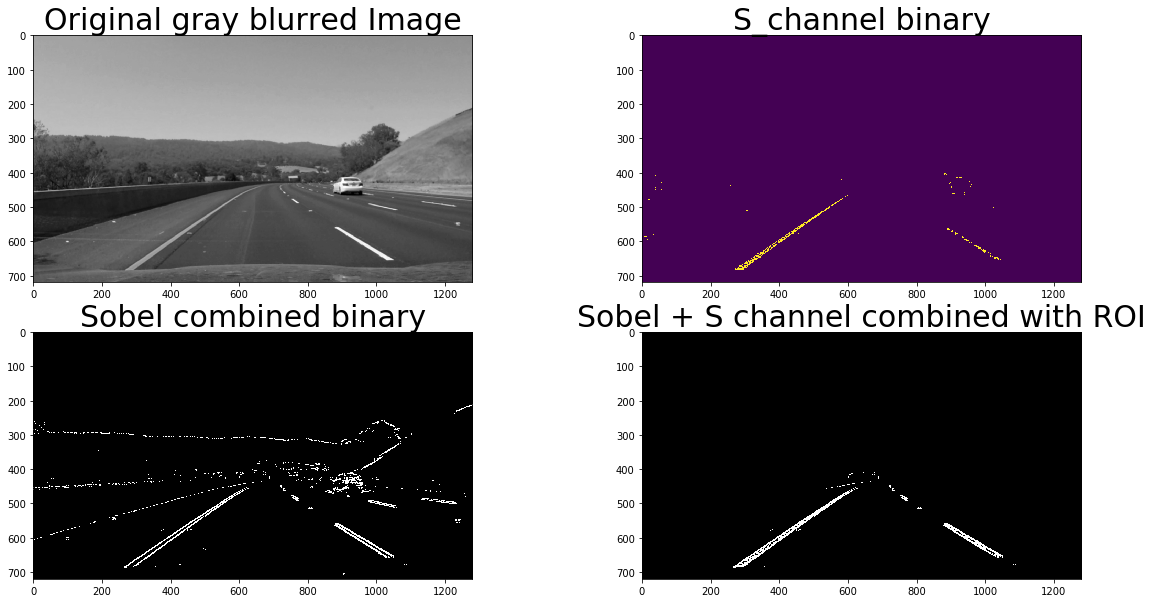

In [225]:
# Test S channel + Sobel function filters

img = cv2.imread('./test_images/test3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])


def pipeline1(img):
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]

    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #print('bgr2gray image shape',gray.shape)
    # Gaussian Blur

    kernel_size = 5
    blur = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)

    # Define sobel kernel size
    ksize = 7
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(blur, orient='x', sobel_kernel=ksize, thresh=(10, 255))
    grady = abs_sobel_thresh(blur, orient='y', sobel_kernel=ksize, thresh=(60, 255))
    mag_binary = mag_thresh(blur, sobel_kernel=ksize, mag_thresh=(40, 255))
    dir_binary = dir_threshold(blur, sobel_kernel=ksize, thresh=(.65, 1.05))
    #Directional Binary output is float64, so convert it to uint8
    dir_binary=dir_binary.astype(np.uint8)
    # Combine all the thresholding information
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    # Threshold color channel
    s_binary = np.zeros_like(combined)
    s_binary[(s > 160) & (s < 255)] = 1
    #color_binary = np.dstack(( np.zeros_like(s_binary), s_binary, s_binary)) * 255
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors    
    color_binary = np.zeros_like(combined)
    color_binary[(s_binary > 0) | (combined > 0)] = 1
    

    # Defining vertices for marked area
    imshape = img.shape
    left_bottom = (100, imshape[0])
    right_bottom = (imshape[1]-20, imshape[0])
    apex1 = (610, 410)
    apex2 = (680, 410)
    inner_left_bottom = (310, imshape[0])
    inner_right_bottom = (1150, imshape[0])
    inner_apex1 = (700,480)
    inner_apex2 = (650,480)
    vertices = np.array([[left_bottom, apex1, apex2, \
                            right_bottom, inner_right_bottom, \
                            inner_apex1, inner_apex2, inner_left_bottom]], dtype=np.int32)
    # Masked area
    color_binary = region_of_interest(color_binary, vertices)
    
    return color_binary,combined,s_binary,blur

color_binary,combined,s_binary,blur=pipeline1(img)

# Visualize 
fig, axes = plt.subplots(2, 2,figsize=(20,10))

f.subplots_adjust(hspace = .2, wspace=.05)

axes[0, 0].imshow(blur,cmap='gray')
axes[0, 0].set_title('Original gray blurred Image', fontsize=30)

axes[0, 1].imshow(s_binary)
axes[0, 1].set_title('S_channel binary', fontsize=30)

axes[1,0].set_title('Sobel combined binary', fontsize=30)
axes[1,0].imshow(combined,cmap='gray')

axes[1,1].imshow(color_binary,cmap='gray')
axes[1,1].set_title('Sobel + S channel combined with ROI', fontsize=30)
print('...')


...


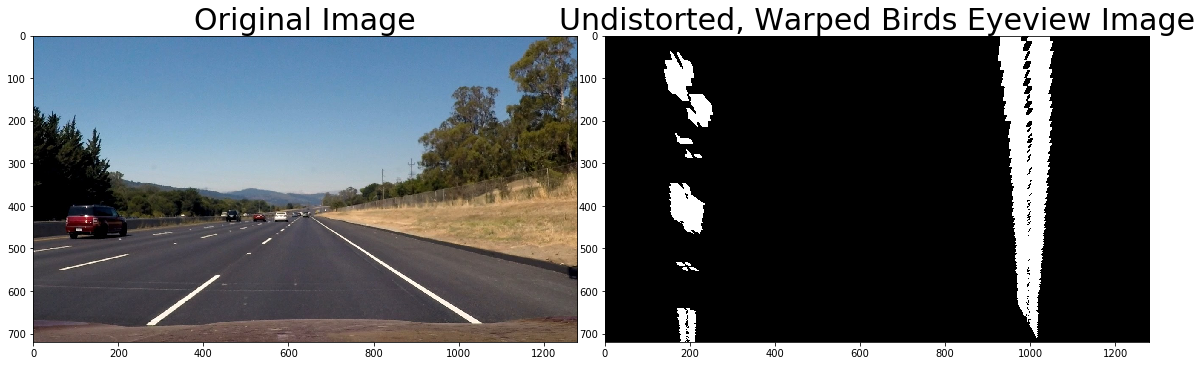

In [226]:
#Combine pipeline1 [Sobel+color filtering] with pipeline2 [Undistort+Warp]

img = cv2.imread('./test_images/straight_lines2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])

color_binary,combined,s_binary,blur=pipeline1(img)

warp, M, Min,src,dst=pipeline2(color_binary)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warp,cmap='gray')
ax2.set_title('Undistorted, Warped Birds Eyeview Image', fontsize=30)
print('...')



In [227]:
#Helper functions to find curvature of lanes
def find_curvature(yvals, fitx):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(yvals)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/520 # meteres per pixel in x dimension
    right_fit_cr = np.polyfit(yvals*ym_per_pix, fitx*xm_per_pix, 2)
    curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return curverad


In [228]:
#Windowed polynomial fit function, to fit lines to detected lanes in a warped image
import numpy as np
import cv2
import matplotlib.pyplot as plt

def window_polyfit(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    #print('out image shape:',out_img.shape)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        #print(out_img)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_curveradius  = find_curvature(ploty, left_fitx)
    right_curveradius = find_curvature(ploty, right_fitx)
    
    #print('left curve:',left_curveradius,'right curve:',right_curveradius)

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    return out_img,left_fitx,right_fitx,ploty,left_curveradius,right_curveradius

(720, 0)

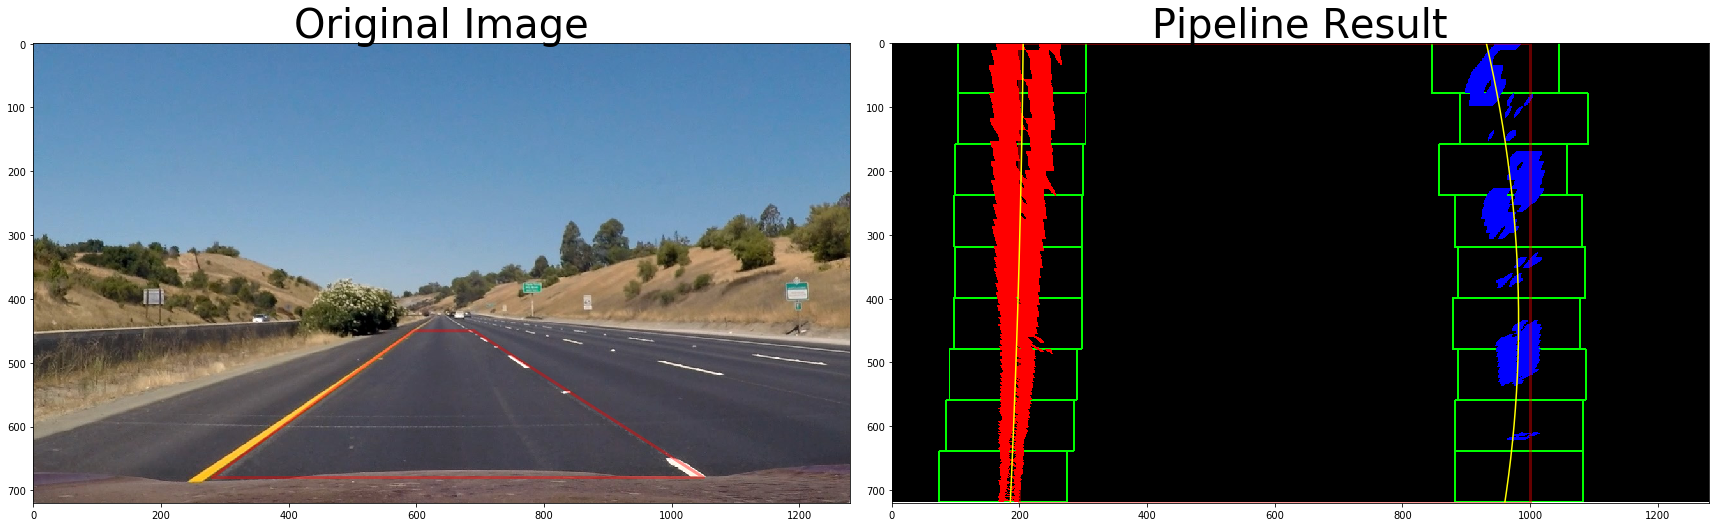

In [229]:
#Test windowed polynomial function

img = cv2.imread('./test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])

color_binary,combined,s_binary,blur=pipeline1(img)

warp, M, Min,src,dst=pipeline2(color_binary)

out_img,left_fitx,right_fitx,ploty,left_curveradius,right_curveradius=window_polyfit(warp)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)

ax2.imshow(out_img)
ax2.set_title('Pipeline Result', fontsize=40)

x = [dst[0][0],dst[2][0],dst[3][0],dst[1][0],dst[0][0]]
y = [dst[0][1],dst[2][1],dst[3][1],dst[1][1],dst[0][1]]
ax2.plot(x, y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)



In [230]:
# Rewarp image from Bird's eyeview into original perspective

def pipeline3(out_img,left_fitx,right_fitx,ploty,left_curveradius,right_curveradius,img):
    image=out_img.astype(np.uint8)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    #print('img shape:',image.shape,image)
    #print('newwarp shape',newwarp.shape,newwarp)
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    # Put text on an image
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Left Lane Radius of Curvature: {} m".format(int(left_curveradius))
    text2 = "Right Lane Radius of Curvature: {} m".format(int(right_curveradius))
    
    cv2.putText(result,text,(400,100), font, 1,(255,255,255),2)
    cv2.putText(result,text2,(400,50), font, 1,(255,255,255),2)
    
    # Find the position of the car
    position_offset=image.shape[1]/2-(pts_left[:,719,0]+pts_right[:,0,0])/2
    #print(position_offset)
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/520 # meteres per pixel in x dimension    
    position_offset_m=position_offset*xm_per_pix
    position=position_offset_m
    #print(position)
    if position < 0:
        text = "Vehicle is {:.2f} m left of center".format(float(-position))
    else:
        text = "Vehicle is {:.2f} m right of center".format(float(position))
    cv2.putText(result,text,(400,150), font, 1,(255,255,255),2)
    return result



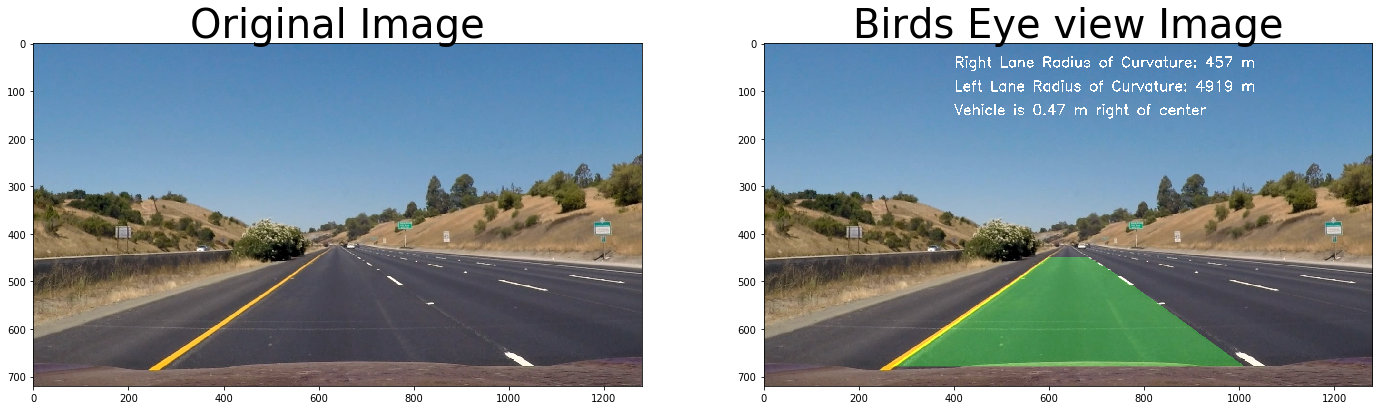

In [231]:
#Test rewarp function
img = cv2.imread('./test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])

color_binary,combined,s_binary,blur=pipeline1(img)

warp, M, Min,src,dst=pipeline2(color_binary)
#print('warp shape:',warp.shape)

out_img,left_fitx,right_fitx,ploty,left_curveradius,right_curveradius=window_polyfit(warp)
result= pipeline3(out_img,left_fitx,right_fitx,ploty,left_curveradius,right_curveradius,img)
#print(len(left_fitx))
#print(len(ploty))

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.set_title('Birds Eye view Image', fontsize=40)

ax2.imshow(result)
plt.show()


In [232]:
#Compile all functions into a single pipeline function for video frame processing

def pipeline(img):
    color_binary,combined,s_binary,blur=pipeline1(img)
    color_binary=color_binary*255
    color_binary_img=np.dstack((color_binary,color_binary,color_binary))
    
    low_threshold=50
    high_threshold=150
    canny_img=cv2.Canny(color_binary_img, low_threshold, high_threshold)
    #print('canny out image shape',canny_img.shape,canny_img.dtype)
    #hough_img=hough_lines(img=canny_img,max_line_gap=100,min_line_len=40,rho=2,theta=np.pi/180,threshold=45)
    
    #h_img=hough_img
    
    warp, M, Min,src,dst=pipeline2(canny_img)
    #print('warp shape:',warp.shape,warp.dtype)

    out_img,left_fitx,right_fitx,ploty,left_curveradius,right_curveradius=window_polyfit(warp)
    result= pipeline3(out_img,left_fitx,right_fitx,ploty,left_curveradius,right_curveradius,img)
    #result=out_img
    return result

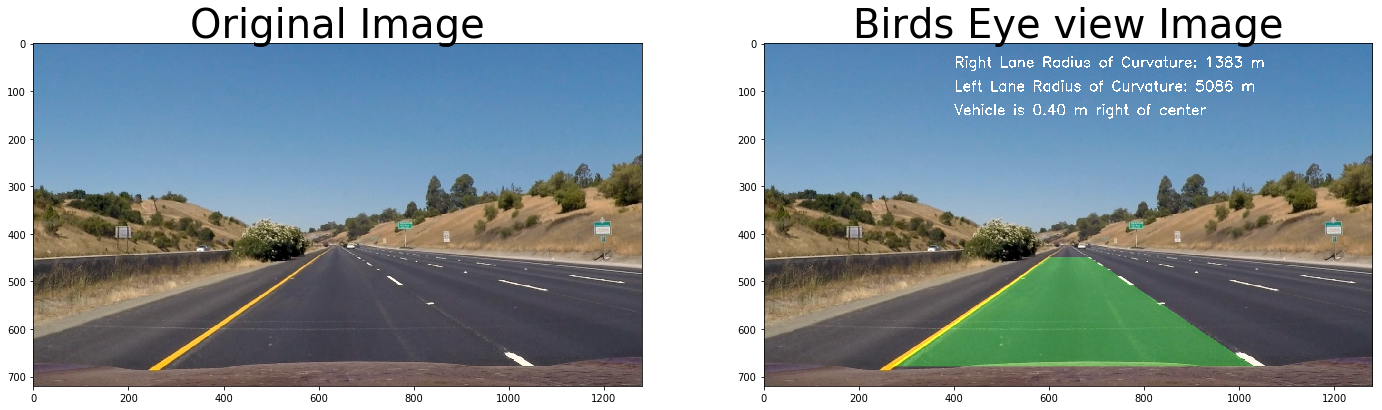

In [233]:
#test pipeline function
import numpy,cv2
numpy.set_printoptions(threshold=1000)

img = cv2.imread('./test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])

#result=pipeline(img)
#result=sub_pipeline(img)
result=pipeline(img)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.set_title('Birds Eye view Image', fontsize=40)

ax2.imshow(result)
plt.show()


In [234]:
### Import everything needed to edit/save/watch video clips
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
from moviepy.editor import VideoFileClip,clips_array
from IPython.display import HTML
# Set up lines for left and right
##left_lane = Line()
#right_lane = Line()
white_output = './final_out.mp4'
#clip1 = VideoFileClip("./clipped_video.mp4")
#clip1 = VideoFileClip("./project_video.mp4")

clip1 = VideoFileClip("./project_video.mp4")
#white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
#sub_pipeline_clip = clip1.fl_image(sub_pipeline) #NOTE: this function expects color images!!
main_pipeline_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
#final_clip = clip1 #NOTE: this function expects color images!!
#final_clip_array = clips_array([[clip1, sub_pipeline_clip],[clip1,main_pipeline_clip]])
#clip2_out = clip1.fl_image(process_image_debug)
#clip2 = clip1.resize(0.70) # downsize 60%
#final_clip = clips_array([[clip1_out, clip2_out]])
#CompositeVideoClip([clip1,clip2,clip3])
                          
%time main_pipeline_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./short_test.mp4
[MoviePy] Writing video ./short_test.mp4


 99%|█████████▉| 175/176 [00:52<00:00,  3.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./short_test.mp4 

CPU times: user 48.7 s, sys: 11.3 s, total: 1min
Wall time: 55.1 s


img uint8
hls uint8
s uint8
gray uint8
blur uint8
gradx uint8
dir_binary before uint8 float64
dir_binary after uint8 uint8
mag_binary uint8
combined uint8
s_binary uint8
color_binary uint8
color_binary after ROI uint8
color_binary shape (720, 1280)
final image shape (720, 1280, 3)
canny out image shape (720, 1280) uint8
hough out image shape (720, 1280, 3) uint8


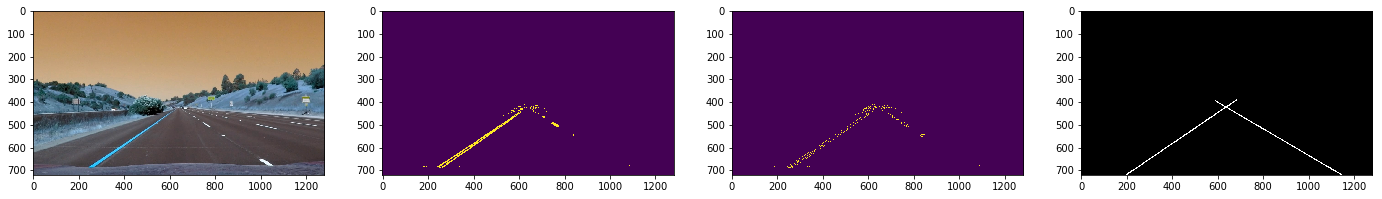

In [35]:
##DIAGNOSTICS ONLY

import cv2
img = cv2.imread('./test_images/straight_lines1.jpg')
print('img',img.dtype)

hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
print('hls',hls.dtype)

s = hls[:,:,2]
print('s',s.dtype)

# Grayscale image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print('gray',gray.dtype)
    
kernel_size = 5
blur = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
print('blur',blur.dtype)
  
# Define sobel kernel size
ksize = 7
# Apply each of the thresholding functions
gradx = abs_sobel_thresh(blur, orient='x', sobel_kernel=ksize, thresh=(10, 255))
print('gradx',gradx.dtype)

grady = abs_sobel_thresh(blur, orient='y', sobel_kernel=ksize, thresh=(60, 255))

mag_binary = mag_thresh(blur, sobel_kernel=ksize, mag_thresh=(40, 255))
dir_binary = dir_threshold(blur, sobel_kernel=ksize, thresh=(.65, 1.05))
print('dir_binary before uint8',dir_binary.dtype)

dir_binary=dir_binary.astype(np.uint8)

#print(dir_binary)
print('dir_binary after uint8',dir_binary.dtype)

print('mag_binary',mag_binary.dtype)

# Combine all the thresholding information
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
print('combined',combined.dtype)

# Threshold color channel
s_binary = np.zeros_like(combined)
s_binary[(s > 160) & (s < 255)] = 1
print('s_binary',s_binary.dtype)

#color_binary = np.dstack(( np.zeros_like(s_binary), s_binary, s_binary)) * 255
# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors    
color_binary = np.zeros_like(combined)
color_binary[(s_binary > 0) | (combined > 0)] = 1
print('color_binary',color_binary.dtype)
#print('color_binary',color_binary)
imshape = img.shape
left_bottom = (100, imshape[0])
right_bottom = (imshape[1]-20, imshape[0])
apex1 = (610, 410)
apex2 = (680, 410)
inner_left_bottom = (310, imshape[0])
inner_right_bottom = (1150, imshape[0])
inner_apex1 = (700,480)
inner_apex2 = (650,480)
vertices = np.array([[left_bottom, apex1, apex2, \
                            right_bottom, inner_right_bottom, \
                            inner_apex1, inner_apex2, inner_left_bottom]], dtype=np.int32)
# Masked area
color_binary = region_of_interest(color_binary, vertices)
print('color_binary after ROI',color_binary.dtype)
print('color_binary shape',color_binary.shape)
color_binary=color_binary*255
color_binary=color_binary.astype(np.uint8)
final_img=np.dstack((color_binary,color_binary,color_binary))
print('final image shape',final_img.shape)
img3=final_img

low_threshold=50
high_threshold=150
canny_img=cv2.Canny(img3, low_threshold, high_threshold)
print('canny out image shape',canny_img.shape,canny_img.dtype)

face

hough_img=hough_lines(img=canny_img,max_line_gap=100,min_line_len=40,rho=2,theta=np.pi/180,threshold=45)
print('hough out image shape',hough_img.shape,hough_img.dtype)

f, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(24, 9))
ax1.imshow(img)
ax2.imshow(color_binary)
ax3.imshow(canny_img)

#print(np.max(color_binary))
ax4.imshow(hough_img)


